# Compare averaging methods for spectrum calculation (ASD, PSD, CSD)


Authors: Pooya Saffarieh <p.saffarieh@nikhefDOTnl>

<font color=gray>
<h4>References for averaging methods:</h4>
<h4>Daniell averaging method</h4>
Original code authors: Nathan A. Holland, Pooya Saffarieh, Abhinav Petra, Conor Mow-Lowry<br>
Original code associated authors: Sam Scherf<br>
Modified for Spicypy by Artem Basalaev &lt;artemDOTbasalaev@pmDOTme&gt;,<br> 
Reviewed by Christian Darsow-Fromm &lt;cdarsowf@physnet.uni-hamburgDOTde&gt;<br>
Further read: <a href=https://doi.org/10.1063/1.4943292>https://doi.org/10.1063/1.4943292</a><br>
<h4>LPSD averaging method</h4>
Based on LPSD package, see <a href=https://gitlab.com/uhh-gwd/lpsd>https://gitlab.com/uhh-gwd/lpsd</a><br>
Wrapped for Spicypy by Artem Basalaev &lt;artemDOTbasalaev@pmDOTme&gt;,<br> 
Reviewed by Christian Darsow-Fromm &lt;cdarsowf@physnet.uni-hamburgDOTde&gt;<br>
Further read:<br>
Improved spectrum estimation from digitized time series on a logarithmic frequency axis: <a href=https://doi.org/10.1016/j.measurement.2005.10.010>https://doi.org/10.1016/j.measurement.2005.10.010</a>. Authors: Michael Tröbs and Gerhard Heinzel;
<br>
Spectrum and spectral density estimation by the Discrete Fourier transform (DFT), including a comprehensive list of window functions and some new flat-top windows: <a href=http://hdl.handle.net/11858/00-001M-0000-0013-557A-5>http://hdl.handle.net/11858/00-001M-0000-0013-557A-5</a>. Authors: Gerhard Heinzel, Albrecht Rüdiger and Roland Schilling;
<br>
MATLAB Toolbox LTPDA: <a href=https://www.elisascience.org/ltpda/>https://www.elisascience.org/ltpda/</a>. Author:  Martin Hewitson.
<br>
<h4>Welch method is inheriting directly from <a href=https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/>GWpy implementation</a></h4>
</font>

If not done already, install spicypy (uncomment the line below):

In [1]:
# pip install spicypy

## Daniell's vs Welch

I am an experimentalist: <br>
- How I can decide to use Daniell's method or Welch's method? <br>
- What is the difference between Daniell's method and Welch's method? <br>
- Which one is better? <br>

In this section we aim to answer to these question through some experiments. 

Assumptions:
We have some nyquist and resolution requirements and we need both these methods satisfy these requirements.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spicypy.signal.time_series import TimeSeries

# change the size of matplotlib plot size. 
plt.rcParams['figure.figsize'] = [10, 7]
# Color blind friendly plots
plt.style.use('tableau-colorblind10')

Defining the sample parameters.
We have these constraints:
* Daniell's method average size should be an odd number.
* Daniell's method resolution should be equal to the Welch's method reolution
* `frequency_resolution_daniell = daniell_number_averages * (1/total_time)`
* `frequency_resolution_welch = (n_samples/welch_n_samples_per_segment) * (1/total_time)`

### Comparing results on the same signal and with same frequency resolution

In [3]:
n_samples = 9996
total_time = 1 # in seconds
sampling_frequency = n_samples/total_time
nyquist_rate = sampling_frequency/2
true_fft_resolution = 1/total_time
daniell_number_averages = 51 # bigger means worse resolution! (try: 1,3,7,51,91)
welch_n_samples_per_segment = n_samples/daniell_number_averages # bigger means better resolution!

print('Welch samples per segment: \t', int(welch_n_samples_per_segment))
print('Nyquist frequency:      \t', nyquist_rate, 'Hz')
print('fft resolution:         \t', true_fft_resolution, 'Hz')
print('fft resolution Welch:   \t', (n_samples/welch_n_samples_per_segment)*true_fft_resolution, 'Hz')
print('fft resolution Daniell: \t', daniell_number_averages*true_fft_resolution, 'Hz') # This is a interesting formula!

Welch samples per segment: 	 196
Nyquist frequency:      	 4998.0 Hz
fft resolution:         	 1.0 Hz
fft resolution Welch:   	 51.0 Hz
fft resolution Daniell: 	 51.0 Hz


Define input signals: sin waves with two frequencies + some random noise

In [4]:
f1 = 1000
f2 = 300
a1 = 100
a2 = 10
noise_scale = 10

t = np.linspace(0, 1, n_samples)
s1 = a1 * np.sin(2 * np.pi * f1 * t) + a2 * np.sin(2 * np.pi * f2 * t)  + np.random.normal(0, scale=noise_scale, size=n_samples)
signal1 = TimeSeries(s1, sample_rate=sampling_frequency, name = 'Signal 1', unit='meter')

Calculate spectra and plot

In [5]:
# Calculating the ASD (Amplitude Spectral Density = sqrt(PSD))
s1_asd_welch = signal1.asd(fftlength=welch_n_samples_per_segment/n_samples) # fftlength should be in seconds. 
s1_asd_daniell = signal1.asd(method="daniell", number_averages=daniell_number_averages)

Text(0.5, 1.0, 'ASD of Signal 1')

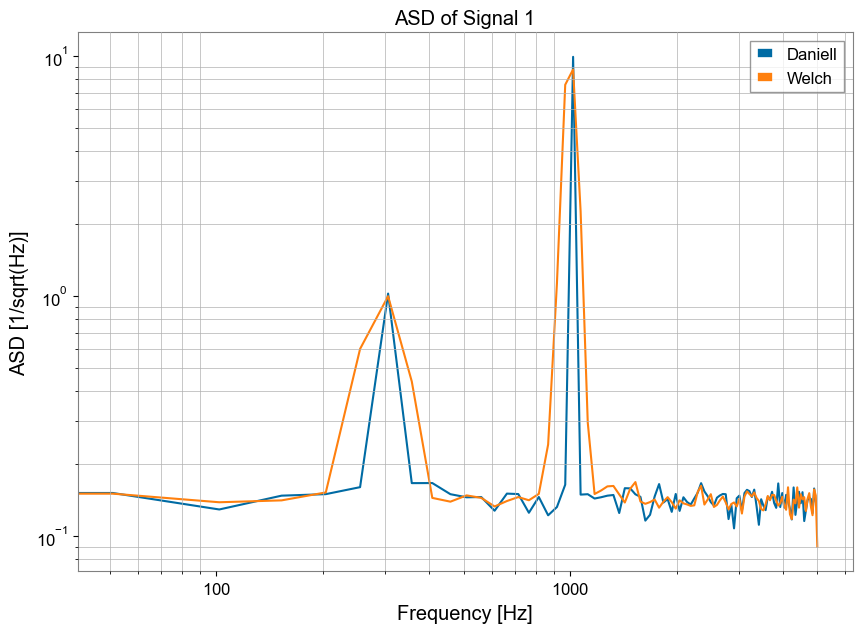

In [6]:
plt.loglog(s1_asd_daniell, label='Daniell')
plt.loglog(s1_asd_welch, label='Welch')
plt.grid(which='both')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [1/sqrt(Hz)]')
plt.title("ASD of Signal 1")

### Effect of less noise in time series (reducing standard deviation of noise)

Now let's try to do everything the same but reduce standard deviation of the noise

In [7]:
noise_scale = 0.1

s2 = a1 * np.sin(2 * np.pi * f1 * t) + a2 * np.sin(2 * np.pi * f2 * t)  + np.random.normal(0, scale=noise_scale, size=n_samples)
signal2 = TimeSeries(s2, sample_rate=sampling_frequency, name = 'Signal 2', unit='meter')

In [8]:
# Calculating the ASD (Amplitude Spectral Density = sqrt(PSD))
s2_asd_welch = signal2.asd(fftlength=welch_n_samples_per_segment/n_samples) # fftlength should be in seconds. 
s2_asd_daniell = signal2.asd(method="daniell", number_averages=daniell_number_averages)

(100, 2000)

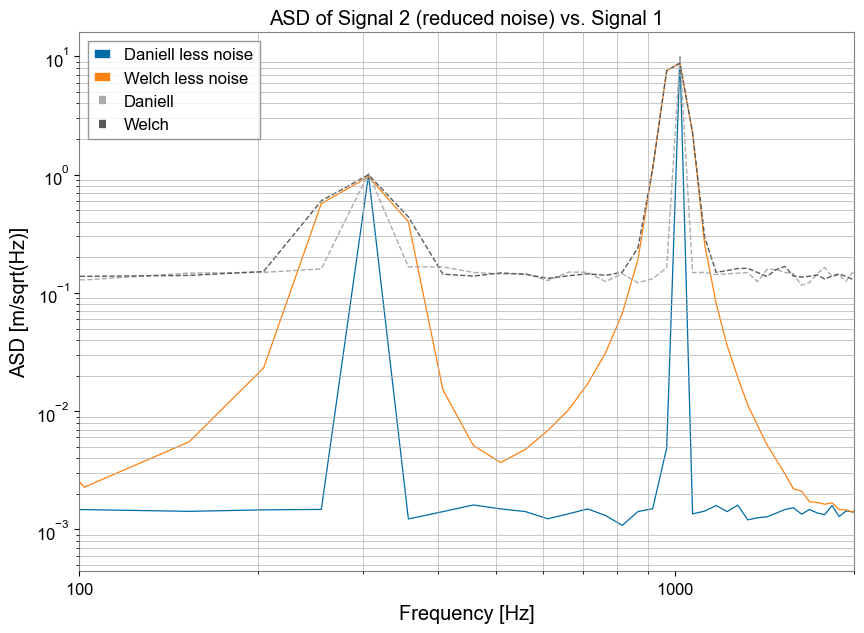

In [9]:
plt.loglog(s2_asd_daniell, label='Daniell less noise', linewidth=0.9)
plt.loglog(s2_asd_welch, label='Welch less noise', linewidth=0.9)
plt.loglog(s1_asd_daniell, label='Daniell', linestyle='dashed', linewidth=1)
plt.loglog(s1_asd_welch, label='Welch', linestyle='dashed', linewidth=1)
plt.grid(which='both')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [m/sqrt(Hz)]')
plt.title("ASD of Signal 2 (reduced noise) vs. Signal 1")
plt.xlim(100,2000)

We can see that resolution of peaks for both method is almost unaffected by the noise level. (especially for the 1000 Hz peak because we have more resoloution in that region compared to 300 Hz).

#### Why Daniell's peaks are narrower?

In Welch, since we cut the original signal into smaller segments and we do windowing on smaller segments, that ruins the coherence of each ocilation which makes peaks wider. In Daniell's method, we also do the windowing but that window is applied to a bigger segment (full signal) which makes the effect of windowing less destructive for the peaks.
In other words, each time we muliply the window to a segment of a signal, we reshape the start and end of each segment. That reshaping spread the power of each ocilation (basis functions) to the neighbouring points (other basis functions with close frequency) which makes the peaks look wider in the spectral density.

### Effect of reducing of window size

Now let's try to reduce window size: by reducing `n_samples_per_segment` in Welch and increasing `number_averages` in Daniell, correspondingly

In [10]:
daniell_number_averages = 91 # bigger means worse resolution!
welch_n_samples_per_segment = (n_samples/true_fft_resolution)*(1/daniell_number_averages) # bigger means better resolution!

print('Welch samples per segment: \t', int(welch_n_samples_per_segment))
print('fft resolution Welch:   \t', 1/(welch_n_samples_per_segment/n_samples), 'Hz')
print('fft resolution Daniell: \t', daniell_number_averages*true_fft_resolution, 'Hz') # This is a interesting formula!

Welch samples per segment: 	 109
fft resolution Welch:   	 91.0 Hz
fft resolution Daniell: 	 91.0 Hz


In [11]:
# Calculating the ASD (Amplitude Spectral Density = sqrt(PSD))
s1_asd_welch_91 = signal1.asd(fftlength=welch_n_samples_per_segment/n_samples) # fftlength should be in seconds. 
s1_asd_daniell_91 = signal1.asd(method="daniell", number_averages=daniell_number_averages)

In [12]:
# Calculating RMS value of f1 ocilation. 
rms_s1_f1_sine = a1/np.sqrt(2)

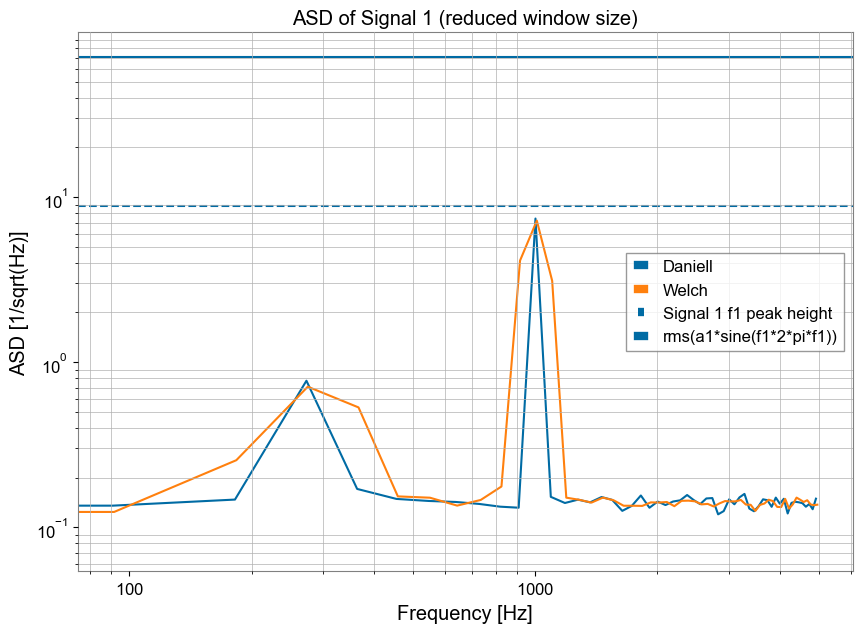

In [13]:
plt.loglog(s1_asd_daniell_91, label='Daniell')
plt.loglog(s1_asd_welch_91, label='Welch')
plt.grid(which='both')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [1/sqrt(Hz)]')
plt.title("ASD of Signal 1 (reduced window size)")
plt.axhline(y=np.max(s1_asd_welch.value), linestyle='--', label='Signal 1 f1 peak height')
plt.axhline(y= rms_s1_f1_sine, linestyle='-', label='rms(a1*sine(f1*2*pi*f1))')
plt.legend()

We get shorter peaks with both methods, but again they are sharper (narrower) with Daniell's.
In both methods by increasing the number of averaging we get wider peaks. 
In no average case, the f1 (1000Hz) peak should approach rms line in the plot.

### Performance when the signal is stochastic

Now we want to see what is the behaviour of each averaging method when the input signal is completely noise.

In [14]:
daniell_number_averages = 7 # bigger means worse resolution! (try: 3,7,51,91)
welch_n_samples_per_segment = (n_samples/true_fft_resolution)*(1/daniell_number_averages) # bigger means better resolution!

print('Welch samples per segment: \t', int(welch_n_samples_per_segment))
print('fft resolution Welch:   \t', 1/(welch_n_samples_per_segment/n_samples), 'Hz')
print('fft resolution Daniell: \t', daniell_number_averages*true_fft_resolution, 'Hz') # This is a interesting formula!

Welch samples per segment: 	 1428
fft resolution Welch:   	 7.0 Hz
fft resolution Daniell: 	 7.0 Hz


In [15]:
noise_scale = 100

s3 = np.random.normal(0, scale=noise_scale, size=n_samples)
signal3 = TimeSeries(s3, sample_rate=sampling_frequency, name = 'Signal 3', unit='meter')

In [16]:
# Calculating the ASD (Amplitude Spectral Density = sqrt(PSD))
s3_asd_welch = signal3.asd(fftlength=welch_n_samples_per_segment/n_samples) # fftlength should be in seconds. 
s3_asd_daniell = signal3.asd(method="daniell", number_averages=daniell_number_averages)

Text(0.5, 1.0, 'ASD of Signal 3')

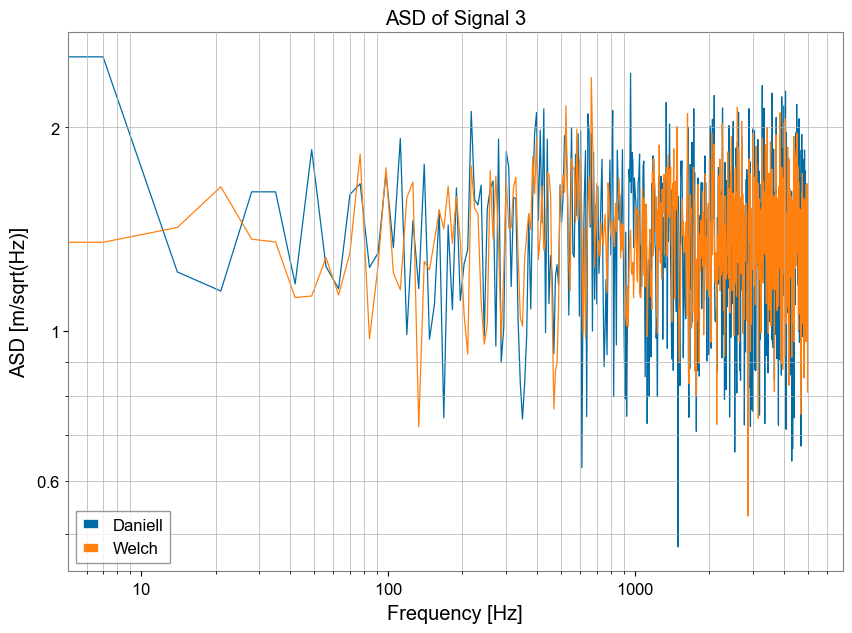

In [17]:
plt.loglog(s3_asd_daniell, label='Daniell', linewidth=0.9)
plt.loglog(s3_asd_welch, label='Welch', linewidth=0.9)
plt.grid(which='both')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [m/sqrt(Hz)]')
plt.title("ASD of Signal 3")

Both methods have pretty much the same performance. Although it is arguable which one of them should have
better performance, inherently. 

## LPSD vs Daniell's with logarithmic binning

LPSD averaging method uses variable binning, increasing exponentially with frequency. This results in a smooth curve over a wide frequency range. Daniell's method now can also be used with logarithmic binning

Text(0.5, 1.0, 'ASD of Signal 1')

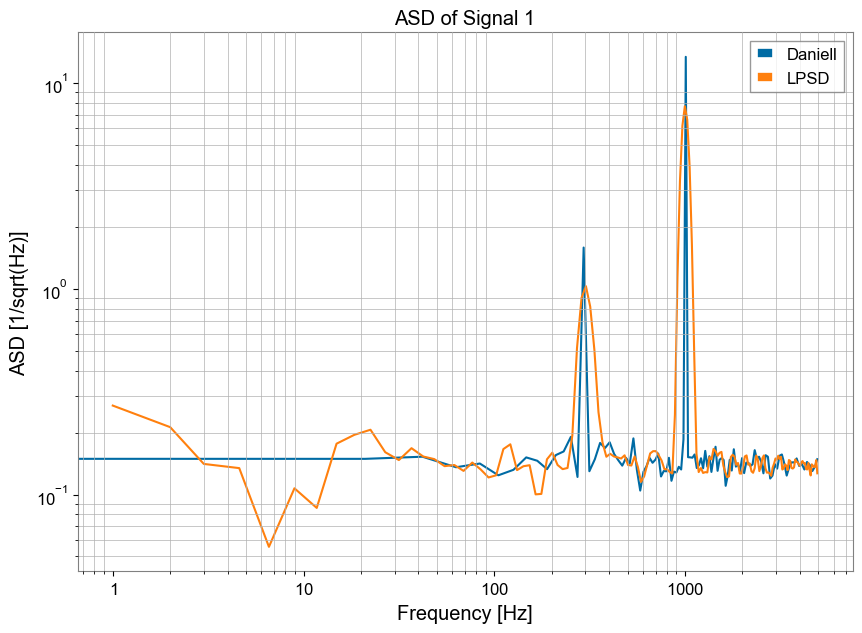

In [20]:
s1_asd_lpsd = signal1.asd(method="lpsd") 
s1_asd_daniell = signal1.asd(method="daniell", number_averages=21, binning="logarithmic", log_base=1.05)
plt.loglog(s1_asd_daniell, label='Daniell')
plt.loglog(s1_asd_lpsd, label='LPSD')
plt.grid(which='both')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [1/sqrt(Hz)]')
plt.title("ASD of Signal 1")

Advantage of logarithmic binning is especially visible for "noisy" Singal 3:

Text(0.5, 1.0, 'ASD of Signal 3')

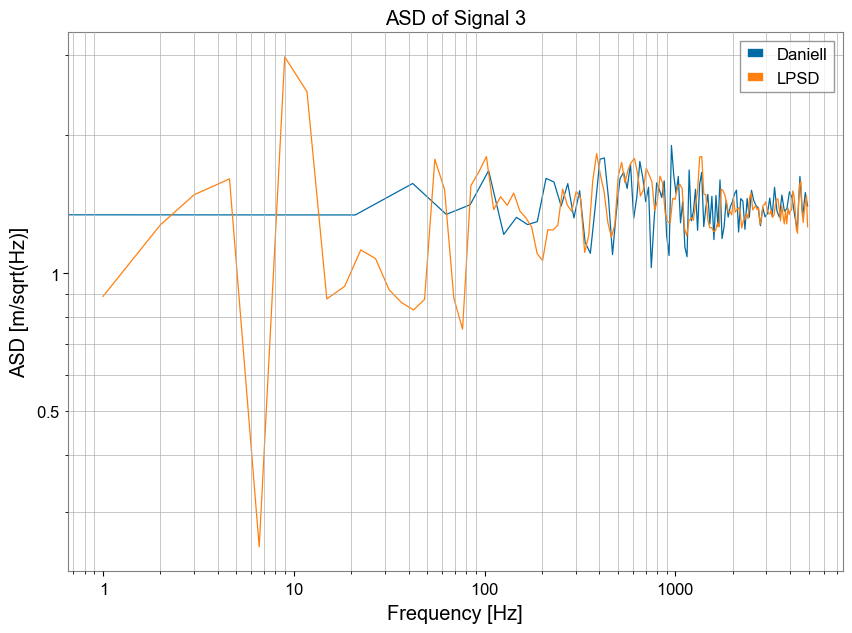

In [21]:
# Calculating the ASD (Amplitude Spectral Density = sqrt(PSD))
s3_asd_lpsd = signal3.asd(method="lpsd") 
s3_asd_daniell = signal3.asd(method="daniell", number_averages=21, binning="logarithmic", log_base=1.05)
plt.loglog(s3_asd_daniell, label='Daniell', linewidth=0.9)
plt.loglog(s3_asd_lpsd, label='LPSD', linewidth=0.9)
plt.grid(which='both')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [m/sqrt(Hz)]')
plt.title("ASD of Signal 3")